In [1]:
# Install libs (Colab)
!pip install -q -U transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [2]:
from transformers import TrainingArguments
print(TrainingArguments)

<class 'transformers.training_args.TrainingArguments'>


In [3]:
# Imports & seed
import random
import numpy as np
import torch

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [4]:
# Charge dataset emotion (Hugging Face)
dataset = load_dataset("emotion")
dataset
# structure: train/validation/test with 'text' and 'label'


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
# Inspect labels
label_names = dataset["train"].features["label"].names
print("Labels:", label_names)
print("Exemple:", dataset["train"][0])

Labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Exemple: {'text': 'i didnt feel humiliated', 'label': 0}


In [6]:
# Choose the model
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
# Tokenization
def preprocess(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized = dataset.map(preprocess, batched=True)
tokenized = tokenized.remove_columns(["text"])  # on garde tokens + label
tokenized.set_format("torch")
tokenized

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [8]:
# Data collator & model init
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
num_labels = len(label_names)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Metrics (accuracy + macro F1)
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    f1m = f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1_macro": f1m}

In [10]:
# Training args
training_args = TrainingArguments(
    output_dir="emotion_model",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    seed=RANDOM_SEED,
    logging_steps=100,
)

In [11]:
# Subset option

USE_SUBSET = False
if USE_SUBSET:
    small_train = tokenized["train"].shuffle(seed=RANDOM_SEED).select(range(2000))
    small_val   = tokenized["validation"].shuffle(seed=RANDOM_SEED).select(range(500))
    small_test  = tokenized["test"].shuffle(seed=RANDOM_SEED).select(range(500))
else:
    small_train = tokenized["train"]
    small_val   = tokenized["validation"]
    small_test  = tokenized["test"]


In [12]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2629283045.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
# Train
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alappattu07 (alappattu07-dsti) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,1.484200
200,0.828000
300,0.510300
400,0.394300
500,0.291000
600,0.273800
700,0.269200
800,0.240400


Step,Training Loss
100,1.484200
200,0.828000
300,0.510300
400,0.394300
500,0.291000
600,0.273800
700,0.269200
800,0.240400
900,0.222200
1000,0.217900


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=3000, training_loss=0.23981015714009604, metrics={'train_runtime': 11425.9859, 'train_samples_per_second': 4.201, 'train_steps_per_second': 0.263, 'total_flos': 584777647046016.0, 'train_loss': 0.23981015714009604, 'epoch': 3.0})

In [14]:
# Evaluate on test set
metrics = trainer.evaluate(eval_dataset=small_test)
print(metrics)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.16469240188598633, 'eval_accuracy': 0.925, 'eval_f1_macro': 0.8747787198659683, 'eval_runtime': 272.2121, 'eval_samples_per_second': 7.347, 'eval_steps_per_second': 0.231, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

     sadness       0.96      0.97      0.96       581
         joy       0.95      0.95      0.95       695
        love       0.83      0.84      0.83       159
       anger       0.93      0.91      0.92       275
        fear       0.86      0.92      0.89       224
    surprise       0.79      0.62      0.69        66

    accuracy                           0.93      2000
   macro avg       0.89      0.87      0.87      2000
weighted avg       0.92      0.93      0.92      2000

Confusion matrix:
 [[561   4   0   8   8   0]
 [  0 659  28   4   0   4]
 [  0  24 134   1   0   0]
 [ 13   3   0 250   9   0]
 [  7   0   0   5 205   7]
 [  3   6   0   0  16  41]]


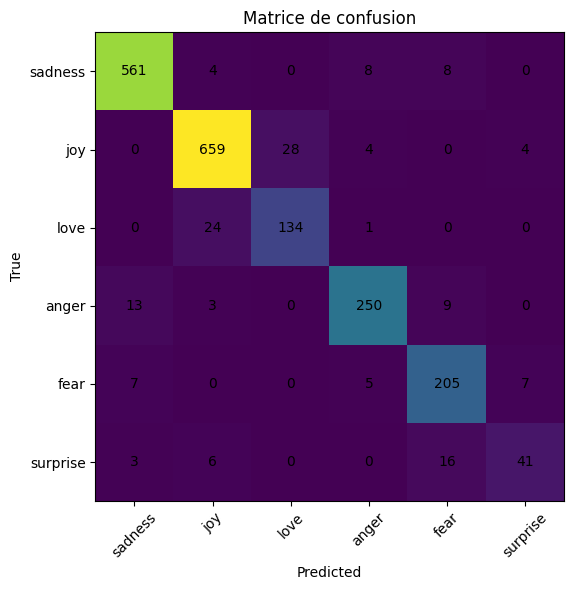

In [15]:
# Predictions + classification report + confusion matrix
preds_output = trainer.predict(small_test)
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

print(classification_report(labels, preds, target_names=label_names))

cm = confusion_matrix(labels, preds)
print("Confusion matrix:\n", cm)

# Plot CM
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Matrice de confusion")
plt.xticks(range(len(label_names)), label_names, rotation=45)
plt.yticks(range(len(label_names)), label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Save model & tokenizer (option: Google Drive)
from pathlib import Path
save_dir = "emotion_model_saved"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
print("Saved to", save_dir)


Saved to emotion_model_saved


## Predict emotions for custom sentences:

In [19]:
# Rebuild pipeline
from transformers import pipeline

model_path = "emotion_model_saved"

# Load model + tokenizer again
emotion_classifier = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=model_path,
    return_all_scores=True
)

# Label mapping (from dataset)
label_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# Now predict properly
texts = [
    "I’m feeling amazing today!",
    "I hate when people lie.",
    "I miss my friends so much.",
    "You make me feel loved ❤️",
    "That movie scared me a lot!"
]

for t in texts:
    preds = emotion_classifier(t)[0]
    preds_sorted = sorted(preds, key=lambda x: x["score"], reverse=True)
    top_label = preds_sorted[0]["label"]
    label_id = int(top_label.split("_")[-1])  # extract number from LABEL_*
    print(f"\nText: {t}")
    print(f"→ Top emotion: {label_names[label_id]} ({preds_sorted[0]['score']:.2f})")



Device set to use cpu



Text: I’m feeling amazing today!
→ Top emotion: joy (0.71)

Text: I hate when people lie.
→ Top emotion: anger (0.97)

Text: I miss my friends so much.
→ Top emotion: sadness (0.99)

Text: You make me feel loved ❤️
→ Top emotion: love (0.99)

Text: That movie scared me a lot!
→ Top emotion: fear (1.00)


In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_path = "./emotion_model_saved"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, trust_remote_code=True)

emotion_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)

Device set to use cpu


In [21]:
print(emotion_classifier("I am so happy today!"))

[[{'label': 'LABEL_0', 'score': 0.00023992746719159186}, {'label': 'LABEL_1', 'score': 0.9990084767341614}, {'label': 'LABEL_2', 'score': 0.0003162057255394757}, {'label': 'LABEL_3', 'score': 0.0002185800258303061}, {'label': 'LABEL_4', 'score': 8.540848648408428e-05}, {'label': 'LABEL_5', 'score': 0.00013146051787771285}]]


## Gradio App

In [22]:
!pip install -q gradio transformers torch

# --- Imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import gradio as gr
from pathlib import Path

# --- Load model directly (since it's local)
model_path = Path("emotion_model_saved")  # your folder in /content

# Load tokenizer and model from that folder
tokenizer = AutoTokenizer.from_pretrained(str(model_path))
model = AutoModelForSequenceClassification.from_pretrained(str(model_path))

# Build pipeline using the actual model objects (avoids HFValidationError)
emotion_classifier = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)

# --- Label mapping
label_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# --- Prediction function
def predict_emotion(text):
    preds = emotion_classifier(text)[0]
    preds_sorted = sorted(preds, key=lambda x: x["score"], reverse=True)
    results = {
        label_names[int(p["label"].split("_")[-1])]: float(p["score"])
        for p in preds_sorted
    }
    return results

# --- Gradio interface
demo = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Textbox(label="💬 Enter a sentence or tweet"),
    outputs=gr.Label(num_top_classes=3, label="Predicted Emotions"),
    title="Emotion Detector 🤖💭",
    description="Type any text to detect emotions using your fine-tuned model!",
    theme="soft",
    examples=[
        ["I’m feeling amazing today!"],
        ["I hate when people lie."],
        ["You make me feel loved ❤️"],
        ["That movie scared me a lot!"]
    ]
)

demo.launch(share=True)


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7f8a5833d688f20581.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
